<a href="https://colab.research.google.com/github/Vaishnavi-Dixit-12/Stock-Prediction-using-LSTM-RNN-and-Tensorflow-2-/blob/main/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a Stock Prediction System using LSTM and Tensorflow 2
(reference from: https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras)

In [ ]:
#!pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn

Uncomment and run the above line of code if the following modules are not installed

In [34]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque
from google.colab import drive

* tensorflow - TensorFlow is an end-to-end open source platform for machine learning
* os - the OS module in Python provides functions for interacting with the operating system.
* numpy - library that provides a simple yet powerful data structure: the n-dimensional array.
* pandas - it is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool,
built on top of the Python programming language.
* random - this module implements pseudo-random number generators for various distributions.
* matplotlib.pyplot - matplotlib.pyplot is a state-based interface to matplotlib. It provides a MATLAB-like way of plotting.
* time - This module provides various time-related functions.

-> yahoo_fin:http://theautomatic.net/yahoo_fin-documentation/


In [35]:
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

**The set.seed()**: *function sets the starting number used to generate a sequence of random numbers – it ensures that you get the same result if you start with that same seed each time you run the same process.*

In [36]:
#Dataset

#shuffle them in unison with respect to their leading indices.
def shuffle_in_unison(a,b):
  state= np.random.get-state()
  np.random.shuffle(a)
  np.random.set_state(state)
  np.random.shuffle(b)

In the below function we will mainly look at:
* -> Check whether the dataframe is already loaded or not
* -> Check feature_columns are present in dataframe
* -> Split the data into train and test.

Loads data from Yahoo Finance source, as well as scaling, shuffling, normalizing and splitting.
    Params:
* ticker (str/pd.DataFrame): the ticker you want to load, examples include AAPL, TESL, etc.
* n_steps (int): the historical sequence length (i.e window size) used to predict, default is 50
* scale (bool): whether to scale prices from 0 to 1, default is True
* shuffle (bool): whether to shuffle the dataset (both training & testing), default is True
* lookup_step (int): the future lookup step to predict, default is 1 
* split_by_date (bool): whether we split the dataset into training/testing by date, setting it 
  to False will split datasets in a random way
* test_size (float): ratio for test data, default is 0.2 (20% testing data)
* feature_columns (list): the list of features to use to feed into the model, default is everything grabbed from yahoo_fin


In [37]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True, test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
  if isinstance(ticker, str):
    df = si.get_data(ticker) #loads the dataframe into df
    print('\nloading data')
  elif isinstance(ticker, pd.DataFrame):
    df = ticker
    print('data already loaded')
  else:
    raise TypeError("Incorrect Ticker")
  #checks if the ticker(i.e. the dataframe) we want to load is already present or not
  
  print('\nData loading complete\n\n')
  print("sample data:\n",df.head(),'\n')
  print('data shape->', df.shape)
  result ={}
  result['df'] = df.copy()
  #return the original dataframe

  #feature_column:
  for column in feature_columns:
    assert column in df.columns, print(f"'{column}' does not exist in the dataframe.") 
  if 'date' not in df.columns:
    df['date'] = df.index
  if scale:
    column_scaler ={} 
    #scale data from 0 to 1

    for column in feature_columns:
      scaler = preprocessing.MinMaxScaler() 
      #This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
      df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
      column_scaler[column] = scaler
    result["column_scaler"] = column_scaler
  
  #checks whether the passed feature_columns exist in dataframe (line 15), add date as column(line 17)
  
  df['future'] =df['adjclose'].shift(-lookup_step) 
  #(look_up = 1) DataFrame.shift(periods=1, freq=None, axis=0, fill_value=<object object>) - Shift index by desired number of periods with an optional time freq.

  last_sequence = np.array(df[feature_columns].tail(lookup_step))
  df.dropna(inplace=True) #drop NaNs (Not A Number)

  sequence_data = []
  sequences = deque(maxlen=n_steps)
  for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
    sequences.append(entry)
    if len(sequences) == n_steps:
        sequence_data.append([np.array(sequences), target])
    # Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end. 
    # if n_steps=x and lookup_step=y, last_sequence should be of x+y length
  
  last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)
  result['last_sequence']= last_sequence #add to result
  # last_sequence will predict future prices that are not mentioned in the dataframe

  #X and y
  X,y =[],[]
  for sequence, target in sequence_data:
    X.append(sequence)
    y.append(target)
  # convert to np 
  X= np.array(X)
  y= np.array(y)

  #splitting the data
  if split_by_date:
      train_samples = int((1 - test_size) * len(X))
      result["X_train"] = X[:train_samples]
      result["y_train"] = y[:train_samples]
      result["X_test"]  = X[train_samples:]
      result["y_test"]  = y[train_samples:]
      # split the dataset into training & testing sets by date (not randomly splitting)
      
      if shuffle:
          # shuffle the datasets for training (NOTE: if shuffle parameter is set)
          shuffle_in_unison(result["X_train"], result["y_train"])
          shuffle_in_unison(result["X_test"], result["y_test"])
  else:    
      # split the dataset randomly
      result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    
    
  dates = result["X_test"][:, -1, -1]
  result["test_df"] = result["df"].loc[dates]
  result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
  result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
  result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
  
  return result    
                                                


* **Create Model:**
the below function is flexible, we can change the values of the parameters in the function.
The function will create a RNN that has a dense layer as output layer with 1 neuro. 

* **Bidirectional Layer:** Bidirectional RNNs
For sequences other than time series (e.g. text), it is often the case that a RNN model can perform better if it not only processes sequence from start to end, but also backwards. For example, to predict the next word in a sentence, it is often useful to have the context around the word, not only just the words that come before it.
Keras provides an easy API for you to build such bidirectional RNNs: the keras.layers.Bidirectional wrapper.




In [38]:
#Creating model
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    
    model = Sequential()
    #A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
  
    #layers
    for i in range(n_layers):
        if i == 0:
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # if condition: first layer; elif condition: last layer; else condition: hidden layers
        
        # add dropout after each layer
        model.add(Dropout(dropout))
        
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [39]:
#load_data parameters
N_STEPS = 50 # Window size or the sequence length
LOOKUP_STEP = 15 # Lookup step, 1 is the next day 
#(value of stock after '15'(value of lookup step) will be predicted)
SCALE = True # whether to scale feature columns & output price as well
SHUFFLE = True # whether to shuffle the dataset
SPLIT_BY_DATE = False # whether to split the training/testing set by date
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

TEST_SIZE = 0.2 # test ratio size, 0.2 is 20%
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"] # features to use

date_now = time.strftime("%Y-%m-%d") # date now


#create_model parameters
N_LAYERS = 2 
CELL = LSTM # LSTM cell
UNITS = 256 # 256 LSTM neurons
DROPOUT = 0.4 
BIDIRECTIONAL = False # whether to use bidirectional RNNs


# training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64 #try changing the value and observe changes in predicted value
EPOCHS = 1 #Try ranging this value from 10-500 and analysis its effect on the accuracy for predicted value

# select the ticker
ticker = "MSFT" #try with values like NFLX, INFY etc.
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

# model name
shuffle_str = f"sh-{int(SHUFFLE)}"
scale_str = f"sc-{int(SCALE)}"
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [40]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("data"):
    os.mkdir("data")

In [41]:
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)
#loads the data


loading data

Data loading complete


sample data:
                 open      high       low     close  adjclose      volume ticker
1986-03-13  0.088542  0.101563  0.088542  0.097222  0.061608  1031788800   MSFT
1986-03-14  0.097222  0.102431  0.097222  0.100694  0.063809   308160000   MSFT
1986-03-17  0.100694  0.103299  0.100694  0.102431  0.064909   133171200   MSFT
1986-03-18  0.102431  0.103299  0.098958  0.099826  0.063258    67766400   MSFT
1986-03-19  0.099826  0.100694  0.097222  0.098090  0.062158    47894400   MSFT 

data shape-> (8877, 7)


In [42]:
data["df"].to_csv(ticker_data_filename)
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
#save dataframe and construct model

* **ModelCheckpoin**t callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.
* **TensorBoard** provides the visualization and tooling needed for machine learning experimentation

In [43]:
checkpoint = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpoint, tensorboard],
                    verbose=1)

111/111 [==============================] - 66s 568ms/step - loss: 0.0010 - mean_absolute_error: 0.0231 - val_loss: 1.3595e-04 - val_mean_absolute_error: 0.0110

Epoch 00001: val_loss improved from inf to 0.00014, saving model to results/2021-06-02_MSFT-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5


In [44]:
#plot graph
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()



In the below get_final_df function
* This function takes the `model` and `data` dict to construct a final dataframe that includes the features along with true and predicted prices of the testing dataset
* 
    

In [45]:
def get_final_df(model, data):
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0

    X_test = data["X_test"]
    y_test = data["y_test"]
    
    y_pred = model.predict(X_test) #predict data
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred # add predicted future prices to the dataframe
   
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test  # add true future prices to the dataframe
    
    test_df.sort_index(inplace=True) # sort the dataframe by date
    final_df = test_df
    
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    ) # add the buy profit column
    
    
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    ) # add the sell profit column

    return final_df

In [46]:
def predict(model, data):
    last_sequence = data["last_sequence"][-N_STEPS:]
    print(last_sequence)
    last_sequence = np.expand_dims(last_sequence, axis=0)
   
    prediction = model.predict(last_sequence)  # get the prediction (scaled from 0 to 1)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]

    # inverting and scaling to get the price
    return predicted_price

For the below block of code
* **model.evaluate()**: Returns the loss value & metrics values for the model in test mode.
* mean absolute error: In statistics, mean absolute error (MAE) is a measure of errors between paired observations expressing the same phenomenon. here mean absolute error is also known as inverse scaling

In [47]:
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)

if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [48]:
final_df = get_final_df(model, data)
future_price = predict(model, data)

#Here we get the final data frame and our predicyed values for the given dataframe

[[0.9008066  0.02702614 0.8799946  0.9000752  0.88453615]
 [0.90687734 0.02849425 0.90759695 0.91584885 0.9111816 ]
 [0.898783   0.02264832 0.9089733  0.9042562  0.904453  ]
 [0.8868706  0.03084834 0.89922446 0.9002273  0.89003444]
 [0.9026774  0.02251213 0.88488805 0.8993531  0.88995755]
 [0.8979431  0.02226696 0.9041562  0.89969516 0.89122635]
 [0.8849998  0.02184394 0.89245766 0.88848263 0.8882273 ]
 [0.8999666  0.0401361  0.8900874  0.9084372  0.8931873 ]
 [0.92508954 0.0272311  0.9113435  0.92265236 0.9149497 ]
 [0.95074695 0.03361546 0.9277444  0.94971454 0.93282866]
 [0.94612706 0.02003711 0.9462862  0.94758606 0.9489006 ]
 [0.9539159  0.01983108 0.94705075 0.9534013  0.9500925 ]
 [0.9667064  0.02071055 0.96601313 0.96560216 0.96858674]
 [0.9766334  0.02139206 0.9663954  0.9726338  0.9702785 ]
 [0.97686255 0.02413314 0.97342986 0.9790193  0.97866046]
 [0.9867131  0.02091677 0.9831786  0.9847965  0.98715776]
 [0.9756407  0.02017213 0.9840197  0.9834282  0.9807368 ]
 [0.9905693  0

We can calculate the accuracy by counting the number of positive profits.
total profit = sum of buy profit + sum of sell profit
dividing it with number of testing samples to get profit per trade

In [49]:
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
total_profit = total_buy_profit + total_sell_profit
profit_per_trade = total_profit / len(final_df)

huber_loss loss: 0.00013594912888947874
Mean Absolute Error: 2.930692600726924


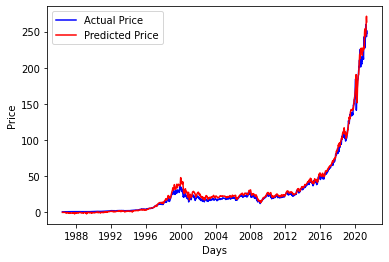

In [50]:
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
plot_graph(final_df)

In [51]:
# printing values

print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 260.87$
Accuracy score: 0.5201361315938741
Total buy profit: 659.1416983604431
Total sell profit: 18.212998121976852
Total profit: 677.35469648242
Profit per trade: 0.3842057268760181
